# Assignment 1

# Density estimation using Real NVP

Normalizing flows are the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to training a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below. 

<img src="2d-example.png" width=600px>


#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution on $X$ by
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density on a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803 ). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
\begin{align}
y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big),
\end{align}

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib).
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import optim
import torch.nn.functional as F
from sklearn import datasets
import time
from multiprocessing import Pool

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f,
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize

        log_det_J = 0.
        for i, layer_mask in enumerate(self.mask):
            z = layer_mask * x
            z += (1 - layer_mask) * (x * torch.exp(self.s[i](layer_mask * x)) + self.t[i](layer_mask * x))
            log_det_J += torch.sum(self.s[i](layer_mask * x) * (1 - layer_mask), dim=1)
            x = z
        return z, log_det_J

    def g(self, z):
        # Compute and return g(z) = x,
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)

        n = len(self.mask)
        for i, layer_mask in enumerate(reversed(self.mask)):
            ind = n - i - 1
            x = layer_mask * z
            x += (1 - layer_mask) * (z - self.t[ind](layer_mask * z)) * torch.exp(-self.s[ind](layer_mask * z))
            z = x
        return x

    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize

        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp

    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)

        z = self.prior.sample((batchSize,))
        z_size = z.size()
        z = z.reshape((z_size[0], 1, z_size[1]))
        x = self.g(z)
        return x

In [3]:
class TranslationShiftNet(nn.Module):
    def __init__(self, dimX):
        super(TranslationShiftNet, self).__init__()
        self.fc1 = nn.Linear(dimX, 20)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(20)
        self.fc2 = nn.Linear(20, 100)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 20)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.bn3 = nn.BatchNorm1d(20)
        self.fc4 = nn.Linear(20, dimX)

    def forward(self, x):
        changed_size = False
        if len(x.size()) == 3:
            # crutches to adjust to make batch noramizations correctly (a, 1, b)
            changed_size = True
            x = x[:, 0, :]
        #x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        x = self.bn1(x)
        #x = F.relu(self.fc2(x))
        #x = torch.sigmoid(self.fc2(x))
        x = torch.tanh(self.fc2(x))
        x = self.bn2(x)
        #x = F.relu(self.fc3(x))
        #x = torch.sigmoid(self.fc3(x))
        x = torch.tanh(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)
        if changed_size:
            # crutches to have correct size of the tensor which is (i don't know why)
            # needed in template of g(x) function
            x_size = x.size()
            x = x.reshape((x_size[0], 1, x_size[1]))
        return x

In [4]:
def return_net():
    return TranslationShiftNet(dimX)

In [5]:
dimX = 2
nets = return_net # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = return_net # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

t = return_net()
s = return_net()
print(t.forward(torch.eye(2)))
print(s.forward(torch.eye(2)))
# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)

tensor([[-0.5135, -0.0070],
        [ 0.0766,  0.2043]], grad_fn=<ThAddmmBackward>)
tensor([[ 0.2535,  0.5342],
        [-0.3012, -0.1182]], grad_fn=<ThAddmmBackward>)


In [6]:
import numpy as np

# torch.Tensor of size #number_of_coupling_layers x #dim(X)
masks = torch.tensor([[1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.]
                     ])

#masks = torch.tensor([[1., 0.], [0., 1.]])
print(masks)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


In [7]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

my_val_log_prob = -np.log(2 * np.pi)
log_prob_1 = prior.log_prob(torch.zeros(2))
log_prob_2 = prior.log_prob(torch.zeros((3, 2))).detach().numpy()
print('mode value of chosen gaussian distribution is \t\t{}'.format(my_val_log_prob))
print('prior.log_prob of [0, 0] returns \t\t\t{}'.format(log_prob_1))
print('prior.log_prob of [[0, 0], [0, 0], [0, 0]] returns \t{}'.format(log_prob_2))

sample = prior.sample()
log_prob_3 = prior.log_prob(sample)
print('sample from prior: \t\t\t\t\t{}'.format(sample.detach().numpy()))
print('log prob of the sample is \t\t\t\t{}'.format(log_prob_3))
# Check that prior has log_prob and sample methods

mode value of chosen gaussian distribution is 		-1.8378770664093453
prior.log_prob of [0, 0] returns 			-1.8378770351409912
prior.log_prob of [[0, 0], [0, 0], [0, 0]] returns 	[-1.837877 -1.837877 -1.837877]
sample from prior: 					[0.99228    0.05394796]
log prob of the sample is 				-2.3316421508789062


In [8]:
flow = RealNVP(nets, nett, masks, prior)
x = torch.ones((5, 2))
z, _ = flow.f(x)
print('initial x = \n{}\n'.format(x))
print('f(x) = \n{}\n'.format(z))
print('g(f(x)) = \n{}\n'.format(flow.g(z)))
print('log_prob of x = {}'.format(flow.log_prob(x)))
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

initial x = 
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

f(x) = 
tensor([[0.6732, 2.4388],
        [0.6732, 2.4388],
        [0.6732, 2.4388],
        [0.6732, 2.4388],
        [0.6732, 2.4388]], grad_fn=<ThAddBackward>)

g(f(x)) = 
tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000]], grad_fn=<ThAddBackward>)

log_prob of x = tensor([-4.5504, -4.5504, -4.5504, -4.5504, -4.5504], grad_fn=<ThAddBackward>)


In [9]:
x = torch.zeros((5, 2))
z, _ = flow.f(x)
print('initial x = \n{}\n'.format(x))
print('f(x) = \n{}\n'.format(z))
print('g(f(x)) = \n{}\n'.format(flow.g(z)))
print('log_prob of x = {}'.format(flow.log_prob(x)))

initial x = 
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

f(x) = 
tensor([[-0.1209,  0.3874],
        [-0.1209,  0.3874],
        [-0.1209,  0.3874],
        [-0.1209,  0.3874],
        [-0.1209,  0.3874]], grad_fn=<ThAddBackward>)

g(f(x)) = 
tensor([[-1.3132e-07,  3.8138e-08],
        [-1.3132e-07,  3.8138e-08],
        [-1.3132e-07,  3.8138e-08],
        [-1.3132e-07,  3.8138e-08],
        [-1.3132e-07,  3.8138e-08]], grad_fn=<ThAddBackward>)

log_prob of x = tensor([-1.4322, -1.4322, -1.4322, -1.4322, -1.4322], grad_fn=<ThAddBackward>)


In [10]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)

# Visualization

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

In [11]:
def generate_circles(n_samples=100):
    noisy_circles_x, noisy_circles_y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
    return noisy_circles_x

def generate_moons(n_samples=100):
    noisy_moons_x, noisy_moons_y = datasets.make_moons(n_samples=n_samples, noise=.05)
    return noisy_moons_x

def generate_from_standard_normal(n_samples=100):
    return prior.sample((n_samples,))

def generate_from_non_standard(n_samples=100):
    return distributions.MultivariateNormal(torch.ones(2) * 3, torch.eye(2) + torch.ones(2)).sample((n_samples,))

def generate_from_mixture_of_normals(n_samples=100):
    X = prior.sample((n_samples,))
    X[:n_samples//2] = distributions.MultivariateNormal(torch.ones(2) * 20, torch.eye(2)).sample((n_samples // 2,))
    return X

## Experiments with mixture of gaussians

In [12]:
%%time
flow = RealNVP(nets, nett, masks, prior)
trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
optimizer = optim.Adam(trainable_parametrs(), lr = 0.001) # choose an optimizer, use module torch.optim

num_iter = 8000
for t in range(num_iter + 1):
    # standard normal
    #batch = generate_from_standard_normal()
    # normal
    #batch = generate_from_non_standard_normal()
    # mixture of normals
    batch = generate_from_mixture_of_normals()

    batch = torch.FloatTensor(batch)
    loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Check that the loss decreases
# Is the visualization below good? Yeah

iter 0: loss = 360.632
iter 500: loss = 4.224
iter 1000: loss = 3.865
iter 1500: loss = 3.766
iter 2000: loss = 3.746
iter 2500: loss = 3.726
iter 3000: loss = 3.588
iter 3500: loss = 3.459
iter 4000: loss = 3.668
iter 4500: loss = 3.708
iter 5000: loss = 3.657
iter 5500: loss = 3.547
iter 6000: loss = 3.627
iter 6500: loss = 3.546
iter 7000: loss = 3.686
iter 7500: loss = 3.560
iter 8000: loss = 3.707
CPU times: user 15min 40s, sys: 13.7 s, total: 15min 53s
Wall time: 22min 5s


Text(0.5,1,'samples from flow')

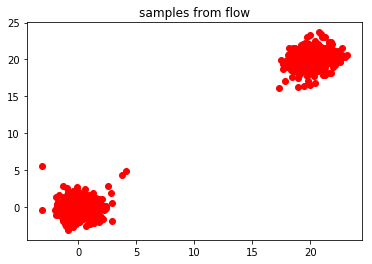

In [13]:
samples_from_flow = flow.sample(batchSize=1000).detach().numpy()
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'ro')
plt.title('samples from flow')

Text(0.5,1,'samples from prior')

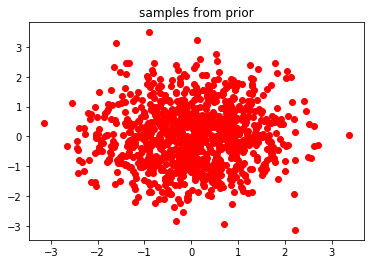

In [14]:
samples = flow.prior.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], 'ro')
plt.title('samples from prior')

Text(0.5,1,'data samples')

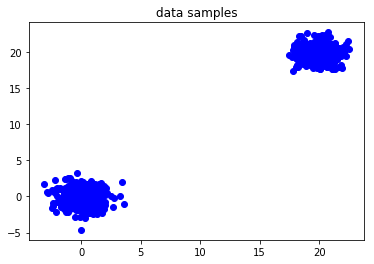

In [15]:
data = generate_from_mixture_of_normals(n_samples=1000).detach().numpy()
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.title('data samples')

Text(0.5,1,'mapping from data to prior')

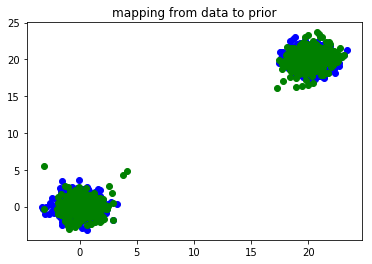

In [16]:
data = generate_from_mixture_of_normals(n_samples=1000).detach().numpy()
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'go')
plt.title('mapping from data to prior')

## Experiments on moons dataset

In [17]:
%%time
flow = RealNVP(nets, nett, masks, prior)
trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
optimizer = optim.Adam(trainable_parametrs(), lr = 0.001) # choose an optimizer, use module torch.optim

num_iter = 3000
for t in range(num_iter + 1):
    # circles
    #batch = generate_circles()
    # moons
    batch = generate_moons()
    # standard normal
    #batch = generate_from_standard_normal()
    # normal
    #batch = generate_from_non_standard_normal()
    # mixture of normals
    #batch = generate_from_mixture_of_normals()

    batch = torch.FloatTensor(batch)
    loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Check that the loss decreases
# Is the visualization below good? Yeah

iter 0: loss = 4.088
iter 500: loss = 0.445
iter 1000: loss = 0.416
iter 1500: loss = 0.454
iter 2000: loss = 0.396
iter 2500: loss = 0.336
iter 3000: loss = 0.275
CPU times: user 6min 7s, sys: 5.59 s, total: 6min 12s
Wall time: 9min 8s


Text(0.5,1,'samples from flow')

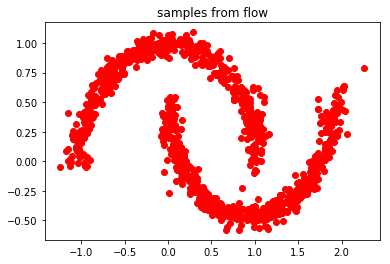

In [18]:
samples_from_flow = flow.sample(batchSize=1000).detach().numpy()
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'ro')
plt.title('samples from flow')

Text(0.5,1,'samples from prior')

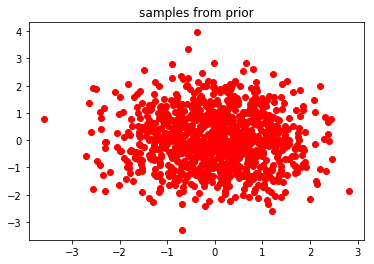

In [19]:
samples = flow.prior.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], 'ro')
plt.title('samples from prior')

Text(0.5,1,'data samples')

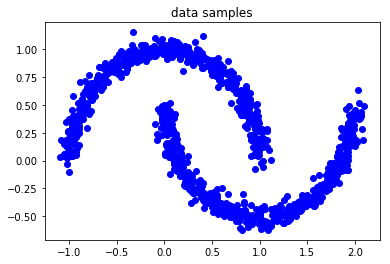

In [20]:
data = generate_moons(n_samples=1000)
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.title('data samples')

Text(0.5,1,'mapping from data to prior')

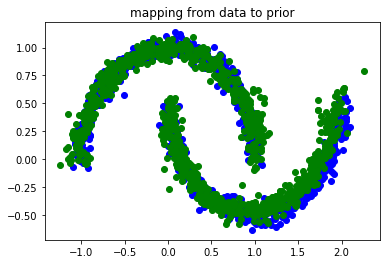

In [21]:
data = generate_moons(n_samples=1000)
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'go')
plt.title('mapping from data to prior')

## Experiments on circles dataset

In [22]:
from sklearn import datasets

flow = RealNVP(nets, nett, masks, prior)
trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
optimizer = optim.Adam(trainable_parametrs(), lr = 0.001)

num_iter = 8000
for t in range(num_iter + 1):
    # circles
    batch = generate_circles()
    # moons
    #batch = generate_moons()
    # standard normal
    #batch = generate_from_standard_normal()
    # normal
    #batch = generate_from_non_standard_normal()
    # mixture of normals
    #batch = generate_from_mixture_of_normals()

    batch = torch.FloatTensor(batch)
    loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Check that the loss decreases
# Is the visualization below good? Yeah

iter 0: loss = 5.429
iter 500: loss = 0.895
iter 1000: loss = 0.944
iter 1500: loss = 0.784
iter 2000: loss = 0.830
iter 2500: loss = 0.907
iter 3000: loss = 0.728
iter 3500: loss = 0.813
iter 4000: loss = 0.700
iter 4500: loss = 0.736
iter 5000: loss = 0.729
iter 5500: loss = 0.839
iter 6000: loss = 0.900
iter 6500: loss = 0.872
iter 7000: loss = 0.753
iter 7500: loss = 0.884
iter 8000: loss = 0.727


Text(0.5,1,'samples from flow')

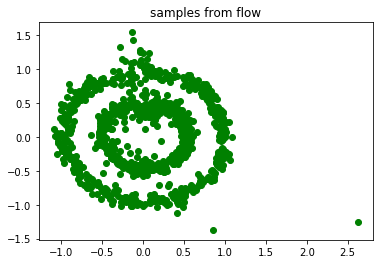

In [23]:
samples_from_flow = flow.sample(batchSize=1000).detach().numpy()
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'go')
plt.title('samples from flow')

Text(0.5,1,'samples from prior')

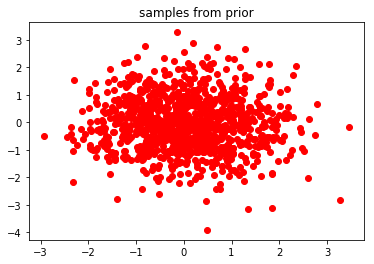

In [24]:
samples = flow.prior.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], 'ro')
plt.title('samples from prior')

Text(0.5,1,'data samples')

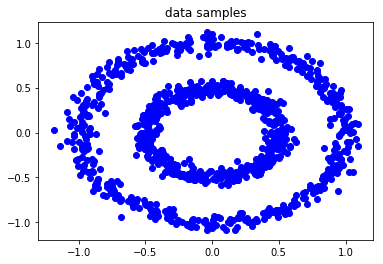

In [25]:
data = generate_circles(n_samples=1000)
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.title('data samples')

Text(0.5,1,'mapping from data to prior')

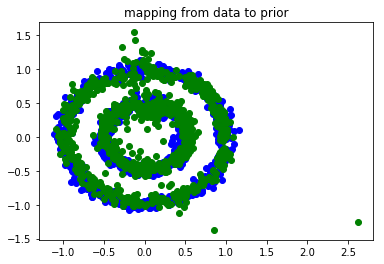

In [26]:
data = generate_circles(n_samples=1000)
plt.plot(data[:, 0], data[:, 1], 'bo')
plt.plot(samples_from_flow[:, 0, 0], samples_from_flow[:, 0, 1], 'go')
plt.title('mapping from data to prior')

## Providde answerrs for the folowing questions:

1. What architecture worked better in your experiments?


Architecture:
At the beginning of testing my code on the circles dataset I thought some simple neural net with 2 coupling layers and 2 fully-connected linear layers would work, but it didn't. Then I tried to make the whole net deeper and it worked bad too even with 16 coupling layers. I also added xavier initialization of parameters and batch normalization layers after all nonlinearities to speed up learning. This all worker better bo not as good as could, so I decided to make the translation and scale nets wider. At the beginning it had 2 fully-connected linear layers and size of vectors was changing as follows: 2->2->2. I experimented with different sizes and stopped with 2->20->100->20->2. As nonlinearity I used ReLU. During this period I found 3 bugs in code of the net (1 in function f(x) and 2 in function g(x), it was amazing that log_prob function was written without mistakes, because it's the most easiest thing - to make mistakes there).

Batch Size:
I tried to use value 10, which is significantly smaller than 100 and the net overfitted, loss was negative, but there were vissible differences between samples from flow and real data. So I decided to leave value 100.

Learning Rate:
The training procedure was unstable and I understood that I needed to decrease learning rate down from $10^{-2}$ to $10^{-3}$ (because the maximum-likelihood loss was jumping with high amplitude). I was using Adam optimizer then and it worked well.

Optimizers:
I also wanted to look what would be if I'd use SGD optimizer instead of Adam. All became worse nan values appeared in loss and trainable parameters. I couldn't undersatand why it happens for a long time, checked my code several times and didn't find any mistakes. Then I tried to decrease learning rate from $10^{-3}$ to $10^{-4}$. It didn't help, nan values were still apearing, so I decrased it to $10^{-5}$ and nan values dissapeared, but the whole net needed more iterations to achive appropriate quallity. Some time after I found that on some iterations with SGD loss was increasing and then became infinite and after that it became equal to nan. It happened with momentum euqal to 0.9 and with it turned off. I retured back to Adam.

Datasets:
I aslo trained my net on the moons dataset and muxture of gaussians and the net works well on them too. Mixture of gaussians was the one with the lowest likelihood among used datasest. Even after 8k iterations the loss was high (maybe it was because the means of the gaussians were located to far from each other and 1 outlier could decrease likelihoos very significantly), but if ingoring that outlier(s), all other samples were from right distribution.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?

I found that SGD optimizer has problems with stability (more concretely I discribed it in the previous questions).
I tried to use ReLU, sigmoid function and tanh. With ReLU training process on circles dataset wasn't stable: it achieved good quality at the most of the launches, but the loss wasn't decreasing monotonously and at some launches it finished with bad quality after 10k iterations. With sigmoid function the whole process was more stable, loss was decreasing almost monotonously (at every 500th iteration), but it take significantly more iterations to achieve the same quality as with ReLU. Tanh was the optimal thing: training process was almost monotonous (after achieving minimum it started to go it another dirrection, but well, Adam has such a problem), training was even faster than with ReLU, always at the end of training loss was pretty low and quality was well with almost perfect match of data samples and samples from the flow (after training with ReLU or sigmoid there sometimes were outlier among the samples, generated by the flow). I also tried the xavier initialization. Before I tried it I needed 10k iteration on circles dataset to achieve well quality. Now I can achieve it with 8k.

## Speed of convergence measurement

3. How convergence speed (in iterations) depends on the complexity of architecture?

All nets in this assignment were trained on batches, so likelihood computed on each iteration can vary. It means, there can't be situations where loss has limit on infinity (except some plateau areas, but there's no garantee that they will be achieved and didn't find such plateau areas with good likelihood in my experiments, only with bad likelihood). So since likelihood would vary, there is no convergence, there is just getting into area, where loss vary, but is near to the best achieved. As long as stochastic gradient is an unbiased estimate of real gradient, taking mean in a mooving window, e.g. mean of current loss, n previous losses and n-1 next would well describe the current state - how far are we from the best position. I made the folowing in my experiments: calculated for internal 10000 - 2n points this mean loss, taken the best of them, added epsilon and found the number of iteration when mean loss has first time become close to the best (difference with the least loss < epsilon). I took 4 values of epsilon: $10^{-1}$, $10^{-2}$, $10^{-3}$, $10^{-4}$ and n = 50, these are not big and not small values. The thing is that choosing large values of epsilon leads to big error of estimation as well as small values of n, but choosing epsilon = 0 leads to error too, because the minimal value can appear in the end of learning just by chance even if for several thousands of iterations the method doesn't go beyond some small area. For each of 4 values of epsilon I trained 16 nets with number of coupling layers in range(1, 16 + 1) and with architecture of translation and scale nets fixed. So number of trainable parameters (which is the formalization of the "complexity" concept) grows linearly.

If the plots with 4 different values of epsilon are similar, we can hope that epsilon is taken from the right range and there are errors linked with too small or too large value of epsilon.

And we can see from the plots that there are almost identical.

Also we can see that the nets with 1 coupling layer can be trained very quickly, then number of iterations raises and then agian becomes less. Maybe if I'd take some larger number of coupling layers than 16, the net would need more iterations to converge, but it's takes a lot of time to train such nets, so I decided to stop with value 16. The main result is that it's not monotonous growth of number of iterations and sometimes it even decreases with growth of number of parameters (not monotonously, but in average, acording to the plots with epsiolon values $10^{-1}$, $10^{-2}$) and remains almost the same (acording to the epsilon values $10^{-4}$) or slightly increases (acording to the value of epsilon $10^{-3}$). So if it's ok to you to stop with some large values of tolerance (epsilon in my terms), the number of iterations may be decrasing or be the same with growing complexity of architecture.

#### eps = $10^{-1}$

In [27]:
%%time

def measure_num_of_iterations(i):
    flow = RealNVP(nets, nett, masks[:i], prior)
    trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
    optimizer = optim.Adam(trainable_parametrs(), lr = 0.001)
    num_of_iter = 10000
    eps = 1e-1
    losses = np.empty(num_of_iter)
    for t in range(num_of_iter):
        batch = generate_circles()
        batch = torch.FloatTensor(batch)
        loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[t] = loss
    mean_losses = np.empty(num_of_iter - 100)
    for j in range (50, num_of_iter - 50):
        mean_losses[j-50] = losses[j-50:j+50].mean()
    min_elem = np.min(mean_losses)
    mask = losses < min_elem + eps
    res = np.min(np.arange(num_of_iter)[mask])
    print('finished training net with {} coupling layers, {} iterations needed'.format(i, res))
    return i, res


masks = torch.tensor([[1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                     ])
pool = Pool(processes=8)
results1 = pool.map(measure_num_of_iterations, range(16, 0, -1))
results1.sort(key=lambda x: x[0])
results1 = [x[1] for x in results1]

finished training net with 9 coupling layers, 397 iterations needed
finished training net with 10 coupling layers, 540 iterations needed
finished training net with 11 coupling layers, 422 iterations needed
finished training net with 12 coupling layers, 656 iterations needed
finished training net with 13 coupling layers, 398 iterations needed
finished training net with 14 coupling layers, 540 iterations needed
finished training net with 15 coupling layers, 434 iterations needed
finished training net with 16 coupling layers, 439 iterations needed
finished training net with 8 coupling layers, 783 iterations needed
finished training net with 7 coupling layers, 517 iterations needed
finished training net with 6 coupling layers, 387 iterations needed
finished training net with 4 coupling layers, 1031 iterations needed
finished training net with 2 coupling layers, 326 iterations needed
finished training net with 5 coupling layers, 989 iterations needed
finished training net with 3 coupling la

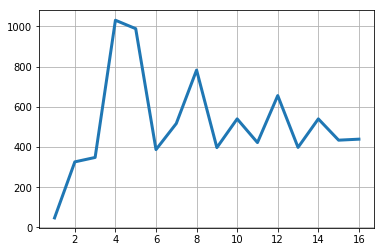

In [28]:
plt.plot(np.arange(1, 16 + 1), results1, linewidth=3)
plt.grid()

#### eps = $10^{-2}$

In [29]:
%%time

def measure_num_of_iterations(i):
    flow = RealNVP(nets, nett, masks[:i], prior)
    trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
    optimizer = optim.Adam(trainable_parametrs(), lr = 0.001)
    num_of_iter = 10000
    eps = 1e-2
    losses = np.empty(num_of_iter)
    for t in range(num_of_iter):
        batch = generate_circles()
        batch = torch.FloatTensor(batch)
        loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[t] = loss
    mean_losses = np.empty(num_of_iter - 100)
    for j in range (50, num_of_iter - 50):
        mean_losses[j-50] = losses[j-50:j+50].mean()
    min_elem = np.min(mean_losses)
    mask = losses < min_elem + eps
    res = np.min(np.arange(num_of_iter)[mask])
    print('finished training net with {} coupling layers, {} iterations needed'.format(i, res))
    return i, res


masks = torch.tensor([[1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                     ])
pool = Pool(processes=8)
results2 = pool.map(measure_num_of_iterations, range(16, 0, -1))
results2.sort(key=lambda x: x[0])
results2 = [x[1] for x in results2]

finished training net with 9 coupling layers, 882 iterations needed
finished training net with 10 coupling layers, 905 iterations needed
finished training net with 11 coupling layers, 711 iterations needed
finished training net with 12 coupling layers, 752 iterations needed
finished training net with 13 coupling layers, 896 iterations needed
finished training net with 14 coupling layers, 980 iterations needed
finished training net with 15 coupling layers, 683 iterations needed
finished training net with 16 coupling layers, 690 iterations needed
finished training net with 8 coupling layers, 1253 iterations needed
finished training net with 6 coupling layers, 683 iterations needed
finished training net with 2 coupling layers, 582 iterations needed
finished training net with 7 coupling layers, 1213 iterations needed
finished training net with 4 coupling layers, 1684 iterations needed
finished training net with 5 coupling layers, 2105 iterations needed
finished training net with 3 coupling

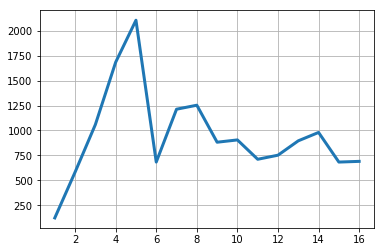

In [30]:
plt.plot(np.arange(1, 16 + 1), results2, linewidth=3)
plt.grid()

#### eps = $10^{-3}$

In [31]:
%%time

def measure_num_of_iterations(i):
    flow = RealNVP(nets, nett, masks[:i], prior)
    trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
    optimizer = optim.Adam(trainable_parametrs(), lr = 0.001)
    num_of_iter = 10000
    eps = 1e-3
    losses = np.empty(num_of_iter)
    for t in range(num_of_iter):
        batch = generate_circles()
        batch = torch.FloatTensor(batch)
        loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[t] = loss
    mean_losses = np.empty(num_of_iter - 100)
    for j in range (50, num_of_iter - 50):
        mean_losses[j-50] = losses[j-50:j+50].mean()
    min_elem = np.min(mean_losses)
    mask = losses < min_elem + eps
    res = np.min(np.arange(num_of_iter)[mask])
    print('finished training net with {} coupling layers, {} iterations needed'.format(i, res))
    return i, res


masks = torch.tensor([[1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                     ])
pool = Pool(processes=8)
results3 = pool.map(measure_num_of_iterations, range(16, 0, -1))
results3.sort(key=lambda x: x[0])
results3 = [x[1] for x in results3]

finished training net with 9 coupling layers, 664 iterations needed
finished training net with 10 coupling layers, 1391 iterations needed
finished training net with 11 coupling layers, 758 iterations needed
finished training net with 12 coupling layers, 896 iterations needed
finished training net with 13 coupling layers, 905 iterations needed
finished training net with 14 coupling layers, 980 iterations needed
finished training net with 15 coupling layers, 1096 iterations needed
finished training net with 16 coupling layers, 1448 iterations needed
finished training net with 8 coupling layers, 1171 iterations needed
finished training net with 2 coupling layers, 696 iterations needed
finished training net with 6 coupling layers, 819 iterations needed
finished training net with 4 coupling layers, 995 iterations needed
finished training net with 7 coupling layers, 1123 iterations needed
finished training net with 5 coupling layers, 2400 iterations needed
finished training net with 3 coupli

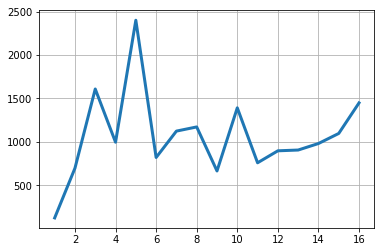

In [32]:
plt.plot(np.arange(1, 16 + 1), results3, linewidth=3)
plt.grid()

#### eps = $10^{-4}$

In [33]:
%%time

def measure_num_of_iterations(i):
    flow = RealNVP(nets, nett, masks[:i], prior)
    trainable_parametrs = flow.parameters # list of all trainable parameters in a flow
    optimizer = optim.Adam(trainable_parametrs(), lr = 0.001)
    num_of_iter = 10000
    eps = 1e-4
    losses = np.empty(num_of_iter)
    for t in range(num_of_iter):
        batch = generate_circles()
        batch = torch.FloatTensor(batch)
        loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses[t] = loss
    mean_losses = np.empty(num_of_iter - 100)
    for j in range (50, num_of_iter - 50):
        mean_losses[j-50] = losses[j-50:j+50].mean()
    min_elem = np.min(mean_losses)
    mask = losses < min_elem + eps
    res = np.min(np.arange(num_of_iter)[mask])
    print('finished training net with {} coupling layers, {} iterations needed'.format(i, res))
    return i, res


masks = torch.tensor([[1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                      [1., 0.], [0., 1.], [1., 0.], [0., 1.],
                     ])
pool = Pool(processes=8)
results4 = pool.map(measure_num_of_iterations, range(16, 0, -1))
results4.sort(key=lambda x: x[0])
results4 = [x[1] for x in results4]

finished training net with 9 coupling layers, 965 iterations needed
finished training net with 10 coupling layers, 1308 iterations needed
finished training net with 11 coupling layers, 1349 iterations needed
finished training net with 12 coupling layers, 1114 iterations needed
finished training net with 13 coupling layers, 683 iterations needed
finished training net with 14 coupling layers, 1219 iterations needed
finished training net with 15 coupling layers, 896 iterations needed
finished training net with 16 coupling layers, 679 iterations needed
finished training net with 8 coupling layers, 1112 iterations needed
finished training net with 2 coupling layers, 759 iterations needed
finished training net with 7 coupling layers, 1088 iterations needed
finished training net with 4 coupling layers, 4373 iterations needed
finished training net with 6 coupling layers, 630 iterations needed
finished training net with 5 coupling layers, 3504 iterations needed
finished training net with 3 coup

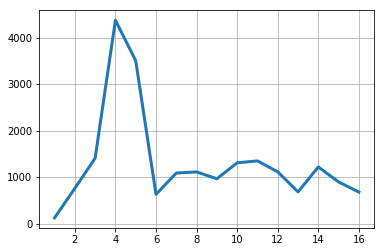

In [34]:
plt.plot(np.arange(1, 16 + 1), results4, linewidth=3)
plt.grid()

# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignment.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, than use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.
